In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-base")
print(tokenizer.all_special_tokens)

#tokenizer.add_tokens(['<some_token_1>', '<some_token_2'>])

#model = T5ForConditionalGeneration.from_pretrained("t5-small")
#model.resize_token_embeddings(len(tokenizer))

/home/jordy/miniconda3/envs/mp_docvqa/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['</s>', '<unk>', '<pad>', '<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_id_44>', '<extra_id_45>', '<extra_id_46>', '<extra_id_47>', '<extra_id_48>', '<extra_id_49>', '<extra_id_50>', '<extra_id_51>', '<extra_id_52>', '<extra_id_53>', '<extra_id_54>', '<extra_id_55>', '<extra_id_56>', '<extra_id_57>

/home/jordy/miniconda3/envs/mp_docvqa/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [2]:
# examples of answers of different types and how we would encode them

single = ["TRIPLE PLAY CONSULTING, Inc.,"]
listtype = [
            "Board of Education",
            "City of Chicago"
        ]
nonetype = []

## Testing tokenization for single

In [15]:
from typing import List

def nonetype_specialtoken(answers:List,tokenizer, value="<NONE>"):
    tokenizer.add_tokens([value])
    return value

def nonetype_empty(answers:List, value=""):
    return value

def listtype_sep(answers:List, separator=" | "):
    return separator.join(answers)

def check_tokenization(answer:str):
    tokenized = tokenizer(answer).input_ids
    decoded = tokenizer.decode(tokenized)
    converted = tokenizer.convert_tokens_to_string(tokenized)

    print("\n".join([str(tokenized), decoded, converted]))


check_tokenization(single[0])
print("----")
check_tokenization(listtype_sep(listtype, separator=" && "))
print("----")
check_tokenization(listtype_sep(listtype))
print("----")
check_tokenization(nonetype_empty(nonetype))
print("----")
check_tokenization(nonetype_empty(nonetype, value=" "))
print("----")
check_tokenization(nonetype_empty(nonetype, value="none"))
print("----")
print("before")
check_tokenization("<NONE>")
print("after")
nonetype_specialtoken(nonetype,tokenizer, value="<NONE>")

[3, 16840, 27872, 17501, 476, 8472, 134, 4254, 21089, 6, 1542, 5, 6, 1]
TRIPLE PLAY CONSULTING, Inc.,</s>
TRIPLE PLAY CONSULTING, Inc.,
----
[2086, 13, 2855, 3, 184, 184, 896, 13, 3715, 1]
Board of Education && City of Chicago</s>
Board of Education && City of Chicago
----
[2086, 13, 2855, 1820, 896, 13, 3715, 1]
Board of Education | City of Chicago</s>
Board of Education | City of Chicago
----
[1]
</s>

----
[1]
</s>

----
[5839, 1]
none</s>
none
----
before
[3, 2, 567, 7894, 3155, 1]
<unk> NONE></s>
⁇ NONE>
after


'<NONE>'

In [18]:
print("before")
check_tokenization("NA")
print("after")
nonetype_specialtoken(nonetype,tokenizer, value="NA")

before
[10144, 1]
NA</s>
NA
after


'NA'

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

input_ids = tokenizer("The <extra_id_0> walks in <extra_id_1> park", return_tensors="pt").input_ids
labels = tokenizer("<extra_id_0> cute dog <extra_id_1> the <extra_id_2>", return_tensors="pt").input_ids

# the forward function automatically creates the correct decoder_input_ids
loss = model(input_ids=input_ids, labels=labels).loss
loss.item()

#additional_special_tokens

#tokenizer.build_inputs_with_special_tokens

## Check how many tokens answers have on average


In [6]:
import json
FILEPATH = "../save/results/T5_DUDE_concat__2023-02-23_17-25-38.json"
results = json.load(open(FILEPATH, "r"))

answers = [x['pred_answer'] for k, x in results["Scores by samples"].items()]
n_tokens = [len(tokenizer(a).input_ids) for a in answers]
from scipy.stats import describe
describe(n_tokens)

DescribeResult(nobs=6324, minmax=(1, 20), mean=4.609266287160025, variance=14.162817807302295, skewness=2.2471201480632748, kurtosis=5.239790552256563)

In [3]:
import numpy as np
import pandas as pd


FILEPATH = "./trainval_QA-pairs.csv"
df = pd.read_csv(FILEPATH)
df["A"] = df["A"].apply(lambda a: "none" if a == "[]" else str(a))

df["tokenized"] = df["A"].apply(lambda a: tokenizer(a).input_ids)
df["n_tokens"] = df["A"].apply(lambda a: len(tokenizer(a).input_ids))

Token indices sequence length is longer than the specified maximum sequence length for this model (565 > 512). Running this sequence through the model will result in indexing errors


ModuleNotFoundError: No module named 'scipy'

What are the 5 disruptive technologies in 2013, according to IBM?
what is the client recive mmethods in the document?
What is the statements of significant?
How much classroom time is required for a bombardier to become familiar with the bombsight?
How are bounding boxes represented?
What about coverage for behavioral health service?
Which 2 groups did The Honourable Jody Wilson-Raybound that a formal inquiry be conducted in regards to Dr. Hassan Diab's affair?
How many reforms were proposed in the document?
Describe the faculty requirements summary?
How many people are involved in supporting the International Space Station (ISS)?
WHAT KIND OF RED APPLE ENTITY?
What are the plaintiffs accusing the defendants of?
What are the implications of Title 18 Sections 793 and 794, of the U.S. Code as amended?
What is the time and the kind of services offered by the scientists at the First church of Christ?
What is INFLATION KIT?
Is there pink lines ?
How climate change can affect pregnant woman?

<Axes: >

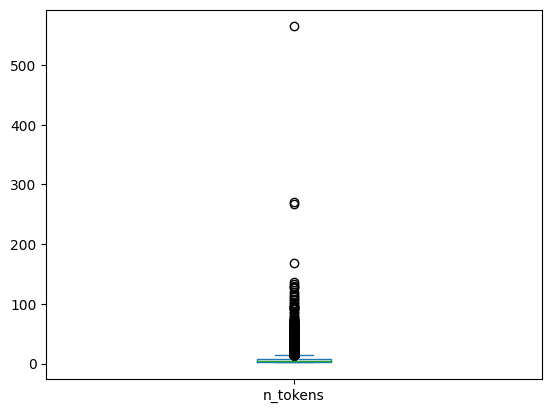

In [20]:
from scipy.stats import describe
describe(df["n_tokens"])

print("\n".join([df["Q"].iloc[i] for i, x in enumerate(df["n_tokens"]) if x > 100]))
df.plot.box(y="n_tokens")#.hist(bins=100)

In [28]:
import scipy.stats as stats
stats.scoreatpercentile(df['n_tokens'], 99.95)

269.43600000000515

## test token addition and initialization strategies


In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-base")
print(len(tokenizer.get_vocab()))
model = T5ForConditionalGeneration.from_pretrained("t5-base")

/home/jordy/miniconda3/envs/mp_docvqa/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jordy/miniconda3/envs/mp_docvqa/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_lengt

32100


In [3]:
#model.encoder.embeddings.word_embeddings.weight
model.shared.weight

Parameter containing:
tensor([[ -0.7539,   0.5977,  -2.4375,  ...,   1.2500,  -0.7891,   3.5156],
        [ 11.3750,  -4.8750,   9.0625,  ...,   4.8438,  14.3750,  -5.7812],
        [-16.6250,  11.0625, -20.8750,  ...,  10.6875,  22.2500,  25.0000],
        ...,
        [  2.2344,   6.7500, -11.0625,  ..., -11.3125,  13.5625,  16.6250],
        [  4.2500,   5.1250, -12.2500,  ..., -11.9375,  13.5000,  17.0000],
        [  4.0625,   6.9688, -12.2500,  ..., -11.3750,  11.9375,  16.6250]],
       requires_grad=True)

In [14]:
import torch
from tqdm import tqdm

def initialize_tokens_by_averaging(tokenizer, model, sorted_tokens):
    with torch.no_grad():
        for idx in range(0, len(sorted_tokens)):

            tokens = tokenizer.tokenize(sorted_tokens[idx])

            tokenized_ids = tokenizer.convert_tokens_to_ids(tokens)

            tokenizer.add_tokens(sorted_tokens[idx])

            model.resize_token_embeddings(len(tokenizer))

            ##model.bert.embeddings.word_embeddings.weight
            #specific to T5

def initialize_tokens_randomly(tokenizer, model, sorted_tokens):

    for idx in range(0, len(sorted_tokens)):
        tokenizer.add_tokens(sorted_tokens[idx])

    # resize embedding layers
    model.resize_token_embeddings(len(tokenizer))
    

QTYPES = ["extractive", "abstractive", "list/abstractive", "list/extractive", "not-answerable"]

initialize_tokens_randomly(tokenizer, model, QTYPES)
print(len(tokenizer.get_vocab()))

initialize_tokens_by_averaging(tokenizer, model, QTYPES)
print(len(tokenizer.get_vocab()))

32105
32105


# confidence estimation

In [ ]:
"""
    decoder_input_ids=prompt_tensors,
    encoder_outputs=encoder_outputs,

gen_sequences = decoder_output.sequences[:, prompt_tensors.shape[-1]:-1]
probs = torch.stack(decoder_output.scores, dim=1).softmax(-1)
gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)
unique_prob_per_sequence = gen_probs.prod(-1)

def compute_logprob(model, input_dict: Dict[str, torch.Tensor]):  # first token is omitted
  labels = input_dict['input_ids']
  outputs = model(**input_dict, labels=labels)
  logits = outputs[1].detach()
  logprobs = F.log_softmax(logits, dim=-1)
  #logprobs = torch.gather(logprobs, -1, input_dict['input_ids'].unsqueeze(-1)).squeeze(-1)
  logprobs = torch.gather(logprobs[:, :-1, :], -1, labels[:, 1:].unsqueeze(-1)).squeeze(-1)
  first_lps = torch.zeros_like(logprobs[:, :1])  # assume the first token always have prob of 1
  logprobs = torch.cat([first_lps, logprobs], 1)
  return logprobs
"""

## Test atype and qtype tokenization

In [7]:
!pip3 install matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 6.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.7/299.7 kB 3.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 4.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 1.5 MB/s eta 0:00:00a 0:00:01


# Confidence seq2seq

In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
 
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

/home/jordy/.virtualenvs/SOTA/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [2]:
input_ids = tokenizer("The <extra_id_0> walks in <extra_id_1> park", return_tensors="pt").input_ids
labels = tokenizer("<extra_id_0> cute dog <extra_id_1> the <extra_id_2>", return_tensors="pt").input_ids

# the forward function automatically creates the correct decoder_input_ids
output = model(input_ids=input_ids, labels=labels)



In [3]:
import torch
import numpy as np 
input_ids = tokenizer("translate English to German: The house is wonderful.", return_tensors="pt").input_ids
output = model.generate(**tokenizer("translate English to German: The house is wonderful.", return_tensors="pt"), output_scores=True,
            return_dict_in_generate=True,
            output_attentions=True)
pred_answers = tokenizer.batch_decode(
    output["sequences"], skip_special_tokens=True
)
bs=1
all_logits = torch.stack(output.scores)
token_logits = np.zeros(len(output["scores"][0]))
for seq_ix in range(len(output["scores"])):
    for batch_ix in range(bs):
        token_id = output.sequences[batch_ix, seq_ix + 1]
        best_logits[batch_ix] += (
            all_logits[seq_ix, batch_ix, token_id]
            if token_id not in tokenizer.all_special_ids
            else 0
        )

print(best_logits)

/home/jordy/.virtualenvs/SOTA/lib/python3.8/site-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[-5.62463284]


SyntaxError: invalid syntax (<ipython-input-34-18a8a62a5e58>, line 1)

In [37]:
special_token_mask= np.zeros((len(output["scores"][0]),bs),dtype=bool) #scores skips first
bs 

for seq_ix in range(len(output["scores"])):
    for batch_ix in range(bs):
        token_id = output.sequences[batch_ix, seq_ix + 1]
        special_token_mask[seq_ix,batch_ix]=bool(token_id not in tokenizer.all_special_ids) 
print(special_token_mask)    
  
decoder_output_confs = torch.amax(torch.stack(output.scores, dim=1).softmax(-1), 2).cpu().numpy() 
print(decoder_output_confs[special_token_mask]) 
 
# add score for end token and wrap scores in a list
decoder_output_confs = [np.concatenate([decoder_output_confs, [1.]], axis=0)]
print(output.sequences[0],pred_answers,decoder_output_confs) 

IndexError: index 1 is out of bounds for axis 0 with size 1

In [25]:
tokenizer.get_vocab()[0]

KeyError: 0

In [20]:
gen_sequences = output.sequences[:, input_ids.shape[-1]:-1]
gen_sequences

tensor([], size=(1, 0), dtype=torch.int64)

In [5]:
import torch

# gen_sequences = decoder_output.sequences[:, prompt_tensors.shape[-1]:-1]
# probs = torch.stack(decoder_output.scores, dim=1).softmax(-1)
# gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)
# unique_prob_per_sequence = gen_probs.prod(-1)
path=logits[0].argmax(-1)
tokenizer.decode(path)

'<extra_id_0> park<extra_id_1><extra_id_1> the<extra_id_2>dog'

In [ ]:
## only use id's that were generated
gen_sequences = generated_outputs.sequences[:, inputs.input_ids.shape[-1]:]
probs = torch.stack(generated_outputs.scores, dim=1).softmax(-1)  # -> shape [3, seqlen, vocab_size]

# now we need to collect the probability of the generated token
# we need to add a dummy dim in the end to make gather work
gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)

# 1) the probs that exactly those sequences are generated again
# those are normally going to be very small
unique_prob_per_sequence = gen_probs.prod(-1)

# 2) normalize the probs over the three sequences
# WEIRD partition function
normed_gen_probs = gen_probs / gen_probs.sum(0)
assert normed_gen_probs[:, 0].sum() == 1.0, "probs should be normalized"

# 3) compare normalized probs to each other like in 1)
unique_normed_prob_per_sequence = normed_gen_probs.prod(-1)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(generated_outputs.sequences):
    print("{}: {}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True), unique_normed_prob_per_sequence[i]))
